In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import RBFInterpolator

Load in calibration images

In [2]:
buffer = 0
mimg = cv2.imread('mimage.png')
width = mimg.shape[1]
limg = cv2.imread('limage.png')[:, :width//2 + buffer]
rimg = cv2.imread('rimage.png')[:, width//2 - buffer:]

Defines function to display image

In [3]:
def disp(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)

Defines function to automatically detect as many corners as possible

In [4]:
def getCorners(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, quality = cv2.goodFeaturesToTrackWithQuality(gimg, maxCorners=200, qualityLevel=0.10, minDistance=7, mask=None)
    return corners

Defines function to display corners

In [5]:
def displayCorners(img, corners, nums=True):
    img = img.copy()
    for i in range(len(corners)):
        point = corners[i]
        cv2.circle(img,(int(point[0][0]),int(point[0][1])),3,(0,0,255),-1)
        if nums:
            cv2.putText(img,str(i),(int(point[0][0]),int(point[0][1])-2),0,0.5,(0,0,255))
    return img

Define Radial Basis Function

In [6]:
def getRBF(actual_corners, ideal_corners):
    print(ideal_corners.shape)
    print(actual_corners.shape)

    filter = actual_corners[:,0,0] != -1.

    pair = np.squeeze(ideal_corners, axis=1)[filter]
    print(pair.shape)

    rbf_x = RBFInterpolator(pair, actual_corners[filter][:,0,0])
    rbf_y = RBFInterpolator(pair, actual_corners[filter][:,0,1])

    return rbf_x, rbf_y, filter

Map image according coeficients

In [7]:
def undistort(new_shape, actual_corners, ideal_corners):
    old_shape = limg.shape[:2]
    fun_x, fun_y, filter = getRBF(actual_corners, ideal_corners)

    x_off = old_shape[0] - new_shape[0]
    y_off = old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return cv2.remap(limg, map_x, map_y, cv2.INTER_LINEAR), map_x, map_y, filter

Get middle camera picture of calibration board

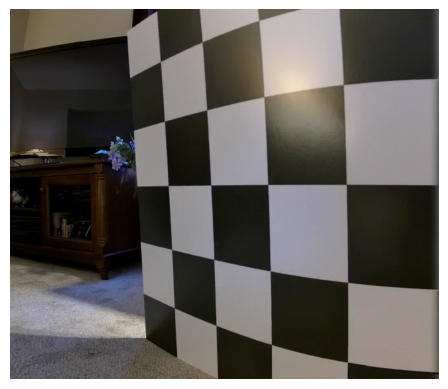

In [8]:
limg = cv2.imread('mimage.png')[:, :width//2 + buffer]
disp(limg)

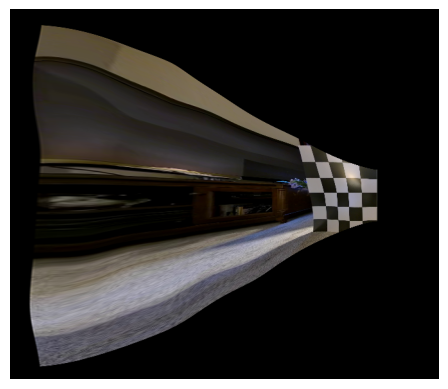

In [9]:
map = np.load('./calibration_np/left_calibration.npy')

per = cv2.remap(limg, map, None, cv2.INTER_CUBIC)
disp(per)

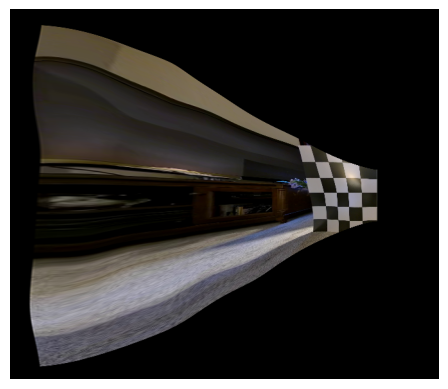

In [10]:
map = np.load('./calibration_np/left_calibration.npy')

per = cv2.remap(limg, map, None, cv2.INTER_CUBIC)
disp(per)

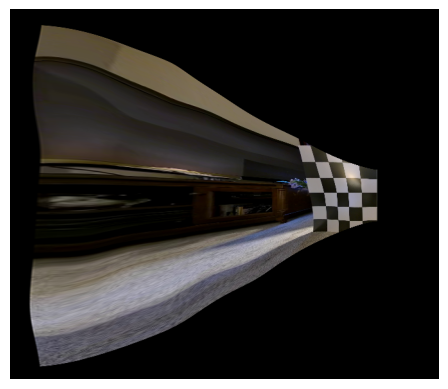

In [11]:
map = np.load('./calibration_np/left_calibration.npy')

per = cv2.remap(limg, map, None, cv2.INTER_CUBIC)
disp(per)

Find potential corners

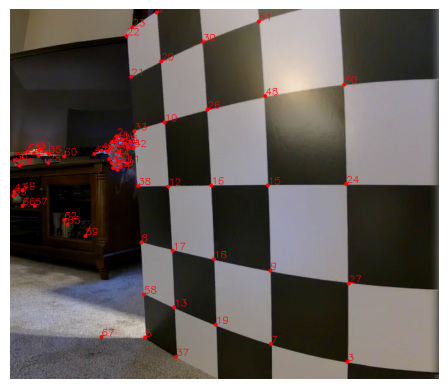

In [12]:
corn = getCorners(limg)
limg_c = displayCorners(limg, corn)
disp(limg_c)

Manually keep incorrect corners

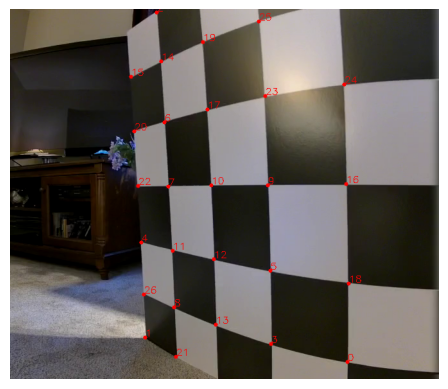

In [13]:
keep = [6, 21, 20, 30, 51, 33, 10, 26, 48, 50, 38, 12, 16, 15, 24, 8, 17, 18, 9,
        27, 58, 13, 19, 7, 3, 5, 37]

mask = [False]*len(corn)
for k in keep:
    mask[k] = True
corn_n = corn[mask]

limg_c = displayCorners(limg, corn_n, True)
disp(limg_c)

Lineup the indexes of the actual corners

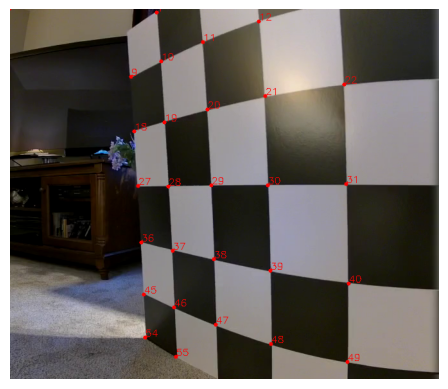

In [14]:
grid_height, grid_width = 7, 9
actual_corners = np.zeros((grid_height*grid_width, 1, 2))-1
map = {2:1,
       15:9, 14:10, 19:11, 25:12,
       20:18, 6:19, 17:20, 23:21, 24:22,
       22:27, 7:28, 10:29, 9:30, 16:31,
       4:36, 11:37, 12:38, 5:39, 18:40,
       26:45, 8:46, 13:47, 3:48, 0:49,
       1:54, 21:55}


assert (sorted(list(map.keys())) == list(range(len(corn_n)))), "map does not map all detected corner points"

for i in range(len(corn_n)):
    actual_corners[map[i]] = corn_n[i]

limg_c = displayCorners(limg, actual_corners, True)
disp(limg_c)

Add Aditional Corners

(576, 668, 3)


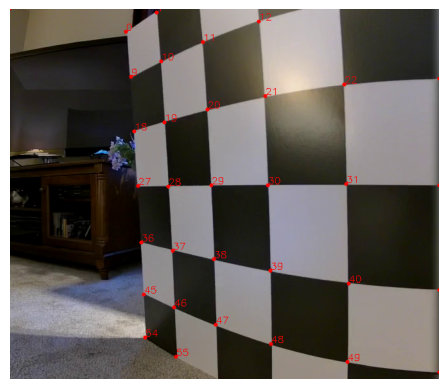

In [15]:
print(limg.shape)
actual_corners[0] = np.array([[180, 35]])
actual_corners[23] = np.array([[668, 108]])
actual_corners[32] = np.array([[668, 274]])
actual_corners[41] = np.array([[668, 437]])
actual_corners[50] = np.array([[668, 565]])

limg_c = displayCorners(limg, actual_corners, True)
disp(limg_c)

Create ideal corner points

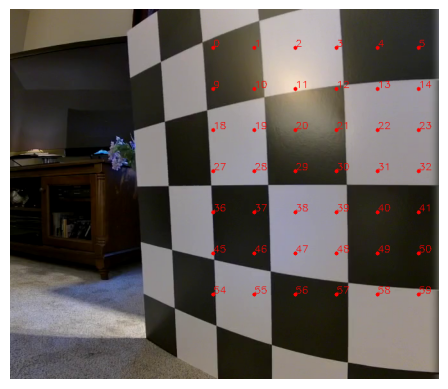

In [16]:
block_len = 64
height, width, _ = limg.shape
ideal_corners = np.zeros((grid_height*grid_width, 1, 2))
start = np.array([60+64*4, 60])

for i in range(grid_height):
    for j in range(grid_width):
        ideal_corners[grid_width*i + j, 0] = start
        start[0] += block_len
    start[1] += block_len
    start[0] -= block_len*grid_width

limg_i = displayCorners(limg, ideal_corners)
disp(limg_i)

Undistort Image

(63, 1, 2)
(63, 1, 2)
(32, 2)


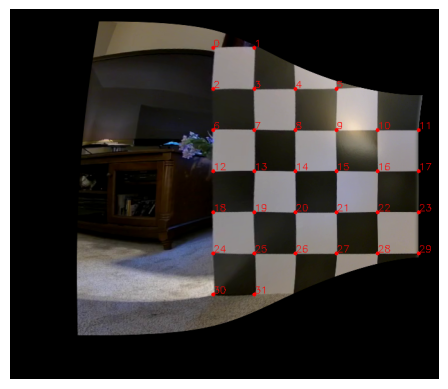

In [17]:
per, map_x, map_y, filter = undistort(limg.shape[:2], actual_corners, ideal_corners)
disp(displayCorners(per, ideal_corners[filter]))

Resize Image